
# Universidad de Buenos Aires
# Deep Learning - Examen - Parte 2
# Junio 2024


El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el **Lunes 24 de junio**. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: maxit1992@gmail.com y lelectronfou@gmail.com). Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-Examen ABRIL 2024.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.

## Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros
- numero de capas.
- numero de kernels.
- tamaño de kernels.


a) Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo y elija el que considera mejor.

b) Al mejor modelo, aplique capas de dropout para ver si puede mejorar sus métricas.



In [5]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

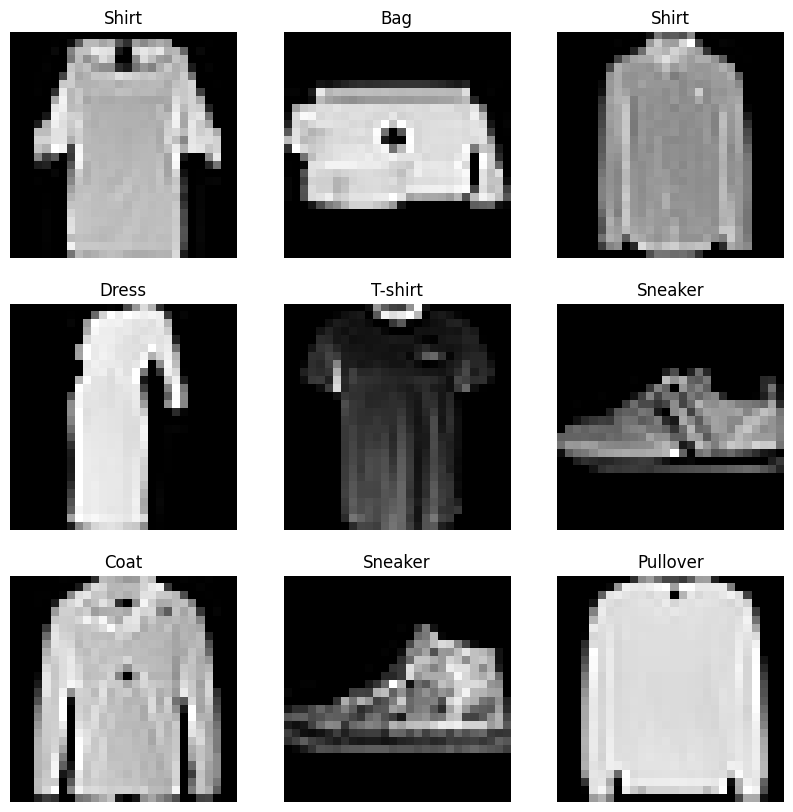

In [3]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [4]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=2)

In [5]:
train_data[0][0][0].shape

torch.Size([28, 28])

In [12]:
class ClothingPredictor(nn.Module):
    def __init__(self, classes_len=len(classes)):
        super(ClothingPredictor, self).__init__()
        self.cnn = nn.Sequential(
            # 28x28x1  
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 28x28x4
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 28x28x8
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 14x14x16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            #7x7x32
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*32, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=32, out_features=classes_len)
        )
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x

In [13]:
model = ClothingPredictor()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.99)
criterion = nn.CrossEntropyLoss()

In [14]:
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(trainloader.dataset)
    return epoch_loss

In [15]:
# Function to evaluate the model
def evaluate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(testloader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy

In [16]:
model.to(device)
epochs = 10

for epoch in range(epochs):
    train_loss = train(model, trainloader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
Train Loss: 2.3031
Test Loss: 2.3026
Test Accuracy: 0.1000


KeyboardInterrupt: 

## Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para procesar las imágenes del dataset MNIST (los números) e identificar los números mayores o menores a 4,5.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. (al reducir el train set, mantenga equilibrada la distribución de las clases!!)

Pruebe 2 estrategias de transfer learning distintas (acorde a los visto en la teoría) y comente para cada una, cual debería funcionar mejor justificando su respuesta.


Compare los resultados finales y comente.

In [ ]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=2)

model = ClothingPredictor()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.99)
criterion = nn.CrossEntropyLoss()

class ClothingPredictor(nn.Module):
    def __init__(self, classes_len=len(classes)):
        super(ClothingPredictor, self).__init__()
        self.cnn = nn.Sequential(
            # 28x28x1  
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 28x28x16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 28x28x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 14x14x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            #7x7x128
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*128, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=classes_len)
        )
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x
    

In [11]:
# Download train data from open datasets.
train_data2 = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor(),)
for i in range(len(train_data2.targets)):
    train_data2.targets[i] = 1 if train_data2.targets[i] > 4 else 0

# Download test data from open datsets.
test_data2 = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor(),)
for i in range(len(test_data2.targets)):
    test_data2.targets[i] = 1 if test_data2.targets[i] > 4 else 0

    